In [1]:
import os
import numpy as np
import torch
import IPython.display as ipd
import matplotlib.pyplot as plt
from audioldm import build_model
from utils.regionutil import region_multidiffusion_text_to_audio, create_temporal_mask, visualize_masks
from utils.vaeutils import sliding_window_vae_decode
from utils.utils import plot_mel_spectrogram, plot_latent_spectrogram
sr = 16000

In [2]:
model = build_model(model_name="audioldm-m-full")
model.cond_stage_model.embed_mode = "text"

Load AudioLDM: %s audioldm-m-full
DiffusionWrapper has 415.95 M params.
DiffusionWrapper has 415.95 M params.


/home/manish/Ayush/audioldm/ldmenv/lib/python3.8/site-packages/torch/nn/utils/weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
/home/manish/Ayush/audioldm/ldmenv/lib/python3.8/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/manish/Ayush/audioldm/ldmenv/lib/python3.8/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Some weights of RobertaModel were not initialized from the model checkpoint a

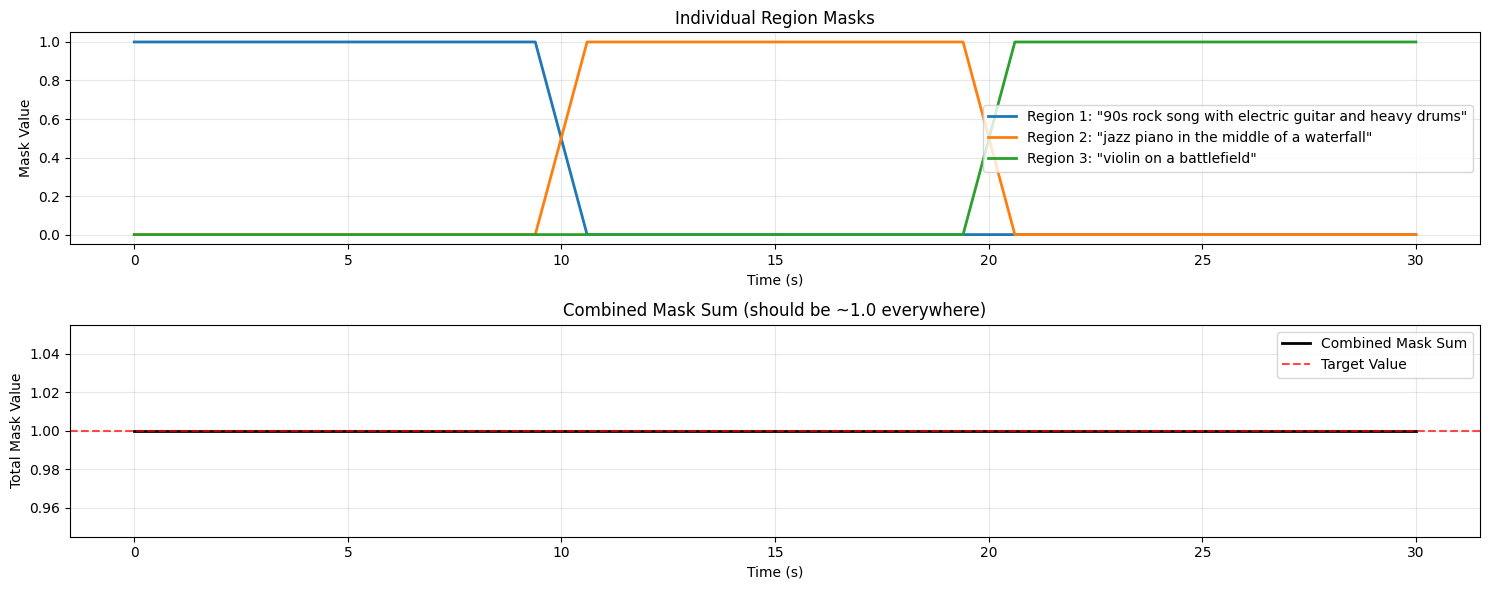

In [3]:
prompts = ["90s rock song with electric guitar and heavy drums", "jazz piano in the middle of a waterfall", "violin on a battlefield"]
duration = 30.0
segment_info = [(0, 10, prompts[0]), (10, 20, prompts[1]), (20, 30, prompts[2])]

from audioldm.pipeline import duration_to_latent_t_size
latent_size = duration_to_latent_t_size(duration)

masks = []
for i, (start_time, end_time, prompt) in enumerate(segment_info):
    # Handle first and last regions specially
    is_first = (i == 0)
    is_last = (i == len(segment_info) - 1)
    
    # Extend boundaries for first/last regions
    if is_first:
        start_time = 0.0
    if is_last:
        end_time = duration
    
    mask = create_temporal_mask(start_time, end_time, latent_size, 
                               is_first_region=is_first, is_last_region=is_last)
    masks.append(mask)

visualize_masks(masks, segment_info, duration)

📊 Generation Settings:
   DDIM steps: 200
   Guidance scale: 3.0
   Chunk frames: 256
   Overlap frames: 192 (75.0%)
🎭 REGION MULTIDIFFUSION: Generating 30.0s audio with 3 regions
  📝 '90s rock song with electric guitar and heavy drums' [0.0s-10.0s]
  📝 'jazz piano in the middle of a waterfall' [10.0s-20.0s]
  📝 'violin on a battlefield' [20.0s-30.0s]
📐 Latent shape: [1, 8, 768, 16]
🎭 CHUNKED MULTIDIFFUSION: Creating masks for 3 regions (no background)
  Region 1: '90s rock song with electric guitar and heavy drums' [0.0s-10.0s] (first=True, last=False)
  Region 2: 'jazz piano in the middle of a waterfall' [10.0s-20.0s] (first=False, last=False)
  Region 3: 'violin on a battlefield' [20.0s-30.0s] (first=False, last=True)
📊 Using 3 region masks (no background)
📊 Visualizing region masks...
📐 Latent shape: [1, 8, 768, 16]
🎭 CHUNKED MULTIDIFFUSION: Creating masks for 3 regions (no background)
  Region 1: '90s rock song with electric guitar and heavy drums' [0.0s-10.0s] (first=True, last=F

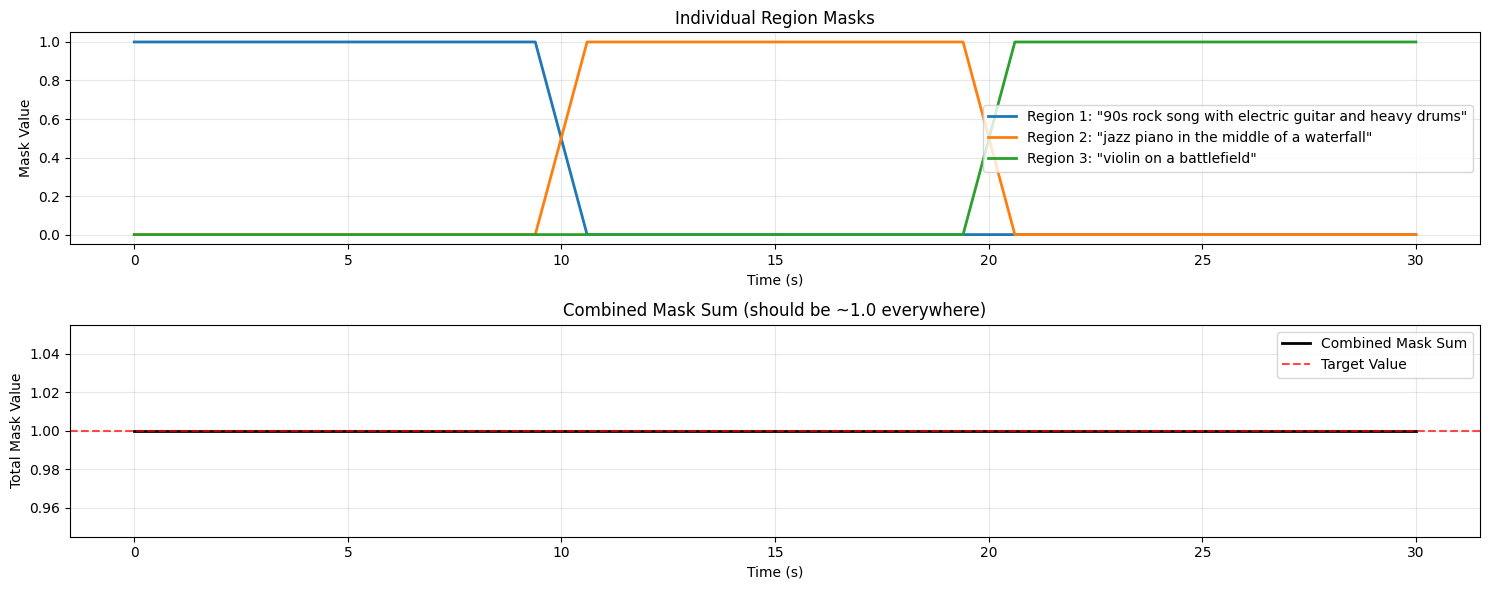

🔄 Starting CORRECT MultiDiffusion with 200 steps
📊 Will process chunks and only generate for active regions per chunk
🪟 Chunk settings: 256 frames, 192 overlap, stride 64


Correct MultiDiffusion:   0%|          | 0/200 [00:00<?, ?it/s]/home/manish/Ayush/audioldm/AudioLDM/utils/regionutil.py:364: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_t = torch.tensor(a_t, device=device)
/home/manish/Ayush/audioldm/AudioLDM/utils/regionutil.py:366: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sigma_t = torch.tensor(sigma_t, device=device)
/home/manish/Ayush/audioldm/AudioLDM/utils/regionutil.py:367: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sqrt_one_minus_at = torch.tensor(sqrt_one_minus_at, device=device)
Corr

Correct MultiDiffusion: 100%|██████████| 200/200 [04:02<00:00,  1.21s/it]



⏱️  Diffusion time: 242.4s
🪟 VAE decoding...
⏱️  VAE time: 0.2s
🔊 Vocoder...
⏱️  Vocoder time: 0.2s
⏱️  Total time: 242.8s
Waveform shape: (1, 1, 491552)
Duration: 0.00s
⏱️  Vocoder time: 0.2s
⏱️  Total time: 242.8s
Waveform shape: (1, 1, 491552)
Duration: 0.00s


In [4]:
ddim_steps = 200
guidance_scale = 3.0

# Chunk hyperparameters - now configurable!
chunk_frames = 256
overlap_ratio = 0.75  # 25% overlap
overlap_frames = int(chunk_frames * overlap_ratio)

print(f"📊 Generation Settings:")
print(f"   DDIM steps: {ddim_steps}")
print(f"   Guidance scale: {guidance_scale}")
print(f"   Chunk frames: {chunk_frames}")
print(f"   Overlap frames: {overlap_frames} ({overlap_ratio*100}%)")

waveform, samples, mel_spectrogram = region_multidiffusion_text_to_audio(
    model=model,
    segment_info=segment_info,
    duration=duration,
    ddim_steps=ddim_steps,
    unconditional_guidance_scale=guidance_scale,
    use_sliding_vae=False,
    return_intermediates=True,
    chunk_frames=chunk_frames,
    overlap_ratio=overlap_ratio
)

print(f"Waveform shape: {waveform.shape}")
print(f"Duration: {len(waveform) / sr:.2f}s")

Final latent shape: torch.Size([1, 8, 768, 16])
✅ Diffusion latent output is clean (no NaN/Inf)


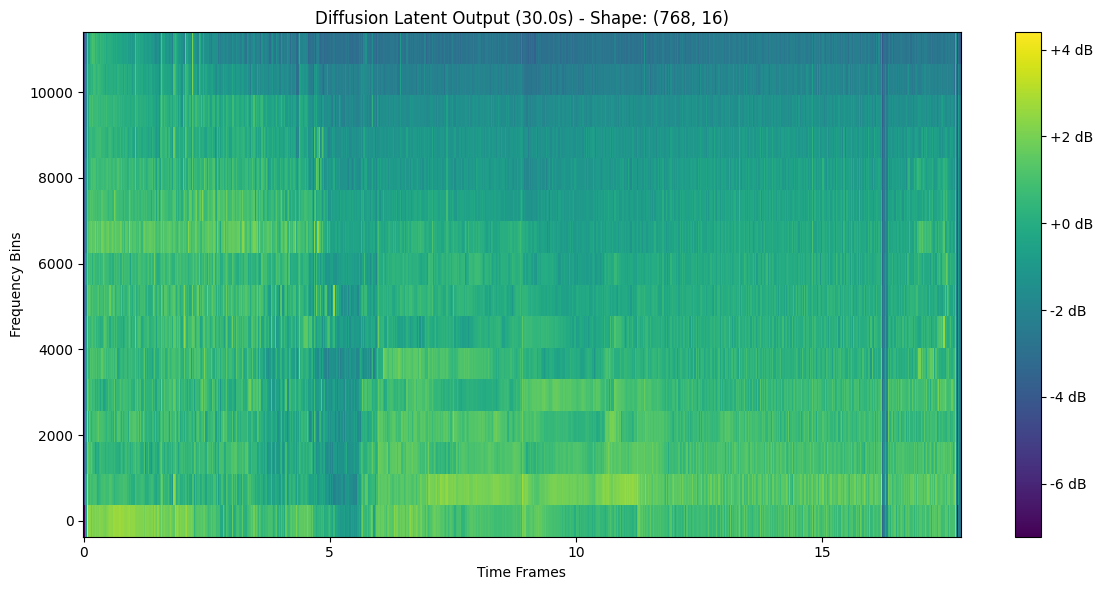

Latent stats - Min: -7.220, Max: 4.399, Mean: -0.129, Std: 1.193


In [5]:
# Visualize diffusion output latent spectrogram
from utils.utils import plot_latent_spectrogram, check_for_nan_inf

print(f"Final latent shape: {samples.shape}")
check_for_nan_inf(samples, "Diffusion latent output")
plot_latent_spectrogram(samples, f"Diffusion Latent Output ({duration}s)")

Mel spectrogram shape: torch.Size([1, 1, 3072, 64])
Latent → Mel conversion factor: 4.00x
Expected mel duration: 30.72s
✅ VAE mel spectrogram output is clean (no NaN/Inf)


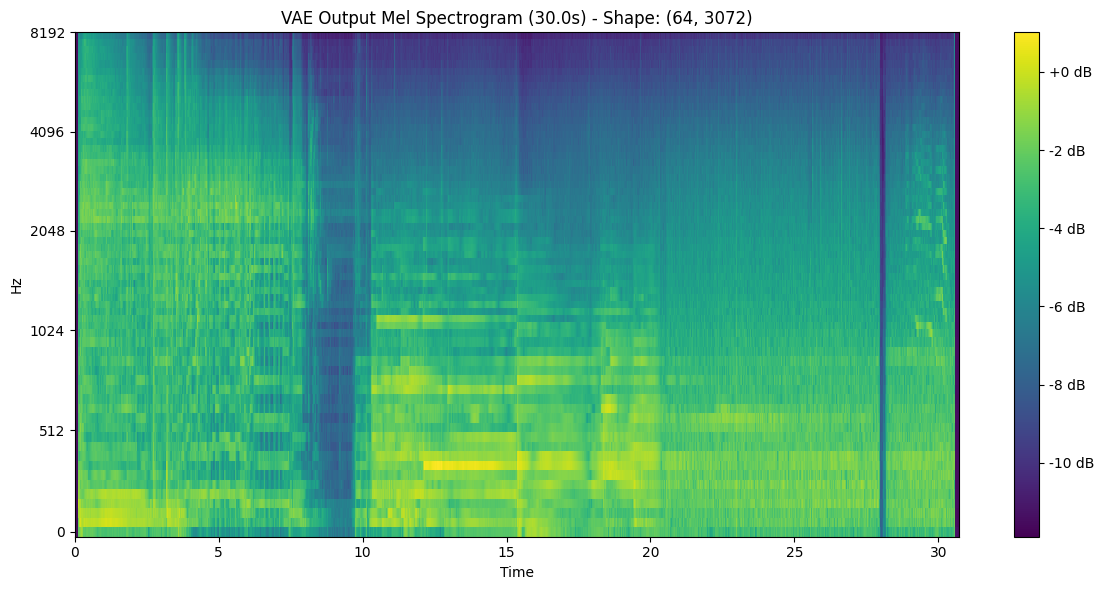

Mel stats - Min: -11.891, Max: 1.010, Mean: -4.898, Std: 2.439


In [6]:
# Visualize VAE output mel spectrogram
from utils.utils import plot_mel_spectrogram

print(f"Mel spectrogram shape: {mel_spectrogram.shape}")
print(f"Latent → Mel conversion factor: {mel_spectrogram.shape[2] / samples.shape[2]:.2f}x")
print(f"Expected mel duration: {mel_spectrogram.shape[2] / 100:.2f}s")  # Using 100 fps for AudioLDM
check_for_nan_inf(mel_spectrogram, "VAE mel spectrogram output")

# Display mel spectrogram
plot_mel_spectrogram(mel_spectrogram, f"VAE Output Mel Spectrogram ({duration}s)", sr=sr)

In [7]:
# Audio Playback
if isinstance(waveform, torch.Tensor):
    waveform_play = waveform.squeeze().cpu().numpy()
else:
    waveform_play = waveform.squeeze()

if len(waveform_play.shape) > 1:
    waveform_play = waveform_play[0]

print(f"🎵 Playing generated audio - Duration: {len(waveform_play) / sr:.2f}s")
ipd.display(ipd.Audio(waveform_play, rate=sr))

🎵 Playing generated audio - Duration: 30.72s
